In [23]:
import re

import numpy as np
import pandas as pd

In [24]:
string_df = pd.read_csv("../../data/interim/string_df.csv")

balanced_pairs_df = pd.read_csv("../../data/interim/balanced_pairs_df.csv", index_col=0)
balanced_pairs_df.drop_duplicates(inplace=True)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [25]:
string_df

,label,concatenated
0,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
1,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
2,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
3,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
4,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
...,...,...
951,iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
952,iPhoneXSMax_M,0001101000101101010000000001101111111111000000...
953,iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
954,iPhoneXSMax_M,0001101000101101010000000001101111111111000000...


In [26]:
print(string_df["label"].value_counts())

label
XiaomiRedmi5_J         104
XiaomiRedmiNote7_S      96
XiaomiRedmiNote9S_T     76
iPhoneXR_L              68
XiaomiRedmi4_B          64
HuaweiHonor9_R          63
XiaomiA2_E              52
iPhone11_M              50
GooglePixel3A_L         45
iPhoneXSMax_M           42
iPhone6_N               38
OnePlusNord_O           35
SamsungJ6_K             26
SamsungS7_I             25
iPhone12_M              25
iPhone7_F               23
iPhone12_W              19
GooglePixel3A_V         18
iPhoneXR_U              17
SamsungM31_A            15
OppoFindX3Neo_A         13
iPhone11_B              10
S21Ultra_M               8
iPhoneXR_A               7
iPhone11_C               6
iPhone7_X                3
iPhone11_F               2
SamsungS4_C              1
HuaweiP10_Q              1
HuaweiP20_G              1
HuaweiL21_D              1
SamsungS6_H              1
iPhone12Pro_C            1
Name: count, dtype: int64


In [27]:
# Assuming 'label' is the column containing the labels you want to exclude
labels_to_exclude = [
    "S21Ultra_M",
    "iPhoneXR_A",
    "iPhone11_C",
    "iPhone7_X",
    "iPhone11_F",
    "SamsungS6_H",
    "iPhone12Pro_C",
    "HuaweiL21_D",
    "HuaweiP10_Q",
    "SamsungS4_C",
    "HuaweiP20_G",
]

# Filter the DataFrame to exclude rows with labels in the list
string_df = string_df[~string_df["label"].isin(labels_to_exclude)]

In [28]:
string_df

,label,concatenated
0,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
1,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
2,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
3,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
4,GooglePixel3A_L,0000000000000000000000000000000000000000000000...
...,...,...
951,iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
952,iPhoneXSMax_M,0001101000101101010000000001101111111111000000...
953,iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
954,iPhoneXSMax_M,0001101000101101010000000001101111111111000000...


## Generate Datasets

In [29]:
import pandas as pd
import numpy as np
from itertools import combinations, product
import random
import matplotlib.pyplot as plt

# Assume string_df is already loaded
# Shuffle the DataFrame to ensure randomness
string_df = string_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Function to create balanced train and test sets
def create_balanced_sets(df, test_size=0.2):
    labels = df["label"].unique()
    train_indices = []
    test_indices = []

    for label in labels:
        label_indices = df[df["label"] == label].index.tolist()
        split_index = int(len(label_indices) * (1 - test_size))
        train_indices.extend(label_indices[:split_index])
        test_indices.extend(label_indices[split_index:])

    train_df = df.loc[train_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)

    return train_df, test_df


# Function to create matching and non-matching pairs
def create_pairs(df, num_pairs):
    pairs = []
    labels = df["label"].unique()

    # Create matching pairs
    matching_pairs = []
    for label in labels:
        label_indices = df[df["label"] == label].index.tolist()
        label_combinations = list(combinations(label_indices, 2))
        matching_pairs.extend([(i, j, 1, label, label) for i, j in label_combinations])

    # Sample matching pairs
    matching_pairs = random.sample(matching_pairs, num_pairs // 2)

    # Create non-matching pairs
    non_matching_pairs = []
    for label1, label2 in combinations(labels, 2):
        label1_indices = df[df["label"] == label1].index.tolist()
        label2_indices = df[df["label"] == label2].index.tolist()
        non_matching_pairs.extend(product(label1_indices, label2_indices))

    # Sample non-matching pairs
    non_matching_pairs = random.sample(non_matching_pairs, num_pairs // 2)

    # Combine pairs
    pairs = matching_pairs + [
        (i, j, -1, df.loc[i, "label"], df.loc[j, "label"])
        for i, j in non_matching_pairs
    ]

    pairs_df = pd.DataFrame(
        pairs, columns=["Item 1", "Item 2", "Equality", "device1", "device2"]
    )
    return pairs_df


# Create train and test sets
train_df, test_df = create_balanced_sets(string_df)

# Determine the number of pairs to create
num_pairs = min(
    len(train_df) * (len(train_df) - 1) // 2,
    len(test_df) * (len(test_df) - 1) // 2,
    2000,
)  # Adjust 2000 to your preferred number

# Create pairs for train and test sets with the same number of entries
train_pairs = create_pairs(train_df, num_pairs)
test_pairs = create_pairs(test_df, num_pairs)

In [30]:
def plot_device_distribution(dataset):
    # Count the occurrences of each device
    device_counts = (
        pd.concat([dataset["device1"], dataset["device2"]]).value_counts().sort_index()
    )

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    device_counts.plot(kind="bar")
    plt.xlabel("Device")
    plt.ylabel("Number of Appearances")
    plt.title("Distribution of Device Appearances in Pairs")
    plt.show()

## Datasets

In [31]:
train_pairs

,Item 1,Item 2,Equality,device1,device2
0,442,464,1,XiaomiRedmiNote9S_T,XiaomiRedmiNote9S_T
1,230,240,1,XiaomiRedmiNote7_S,XiaomiRedmiNote7_S
2,2,24,1,XiaomiRedmi4_B,XiaomiRedmi4_B
3,362,375,1,XiaomiRedmi5_J,XiaomiRedmi5_J
4,351,374,1,XiaomiRedmi5_J,XiaomiRedmi5_J
...,...,...,...,...,...
1995,600,672,-1,iPhone11_M,iPhone12_M
1996,162,396,-1,HuaweiHonor9_R,SamsungM31_A
1997,180,343,-1,HuaweiHonor9_R,XiaomiRedmi5_J
1998,285,694,-1,XiaomiRedmiNote7_S,SamsungJ6_K


In [32]:
test_pairs

,Item 1,Item 2,Equality,device1,device2
0,41,43,1,HuaweiHonor9_R,HuaweiHonor9_R
1,93,94,1,XiaomiRedmi5_J,XiaomiRedmi5_J
2,139,144,1,XiaomiA2_E,XiaomiA2_E
3,7,10,1,XiaomiRedmi4_B,XiaomiRedmi4_B
4,151,154,1,iPhone11_M,iPhone11_M
...,...,...,...,...,...
1995,34,162,-1,GooglePixel3A_L,iPhone6_N
1996,80,184,-1,iPhoneXR_U,GooglePixel3A_V
1997,14,164,-1,iPhoneXR_L,iPhone6_N
1998,77,168,-1,iPhoneXR_U,iPhone12_W


## Distributions

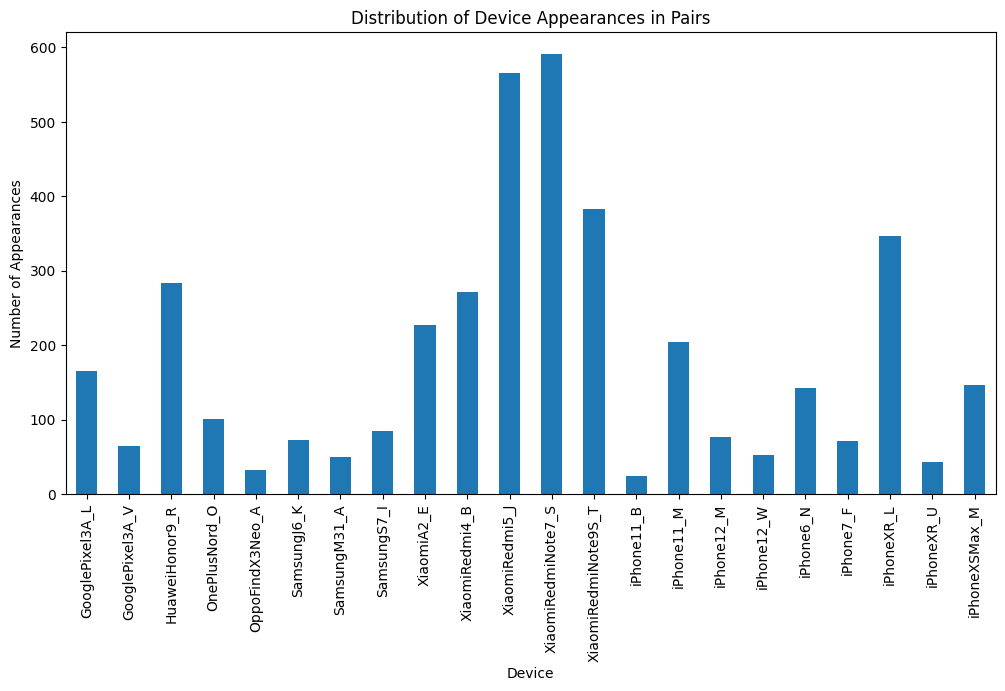

In [33]:
plot_device_distribution(train_pairs)

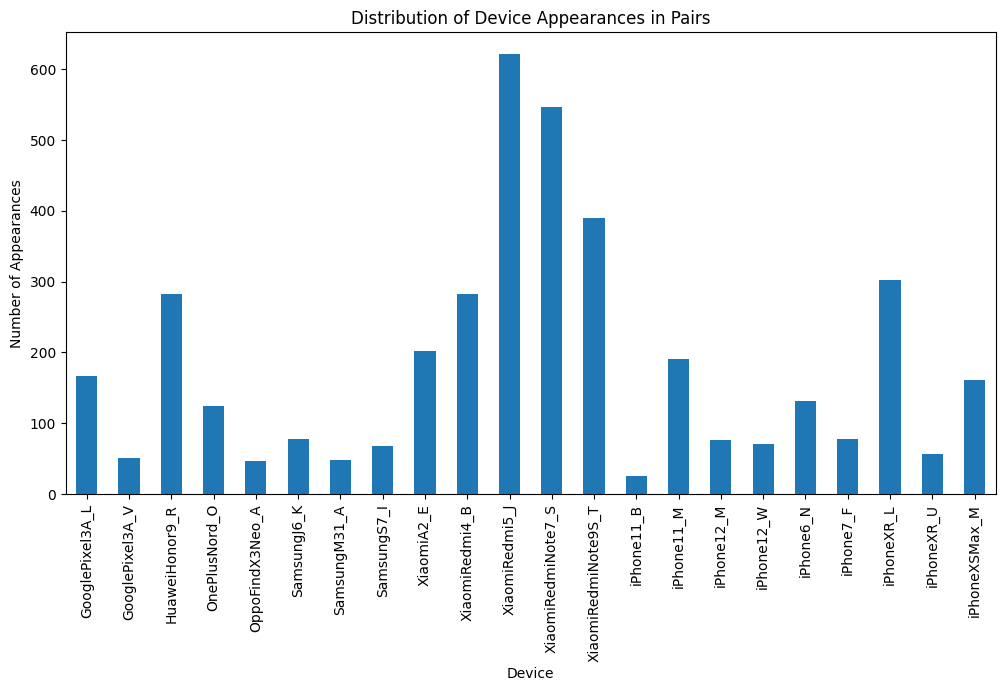

In [34]:
plot_device_distribution(test_pairs)

## Export to CSV

In [35]:
# Optional: Save to CSV
train_pairs.to_csv("train_pairs.csv", index=False)
test_pairs.to_csv("test_pairs.csv", index=False)